In [1]:
import numpy as np
import pandas as pd
# 맷플롯립 설정
%matplotlib inline
import matplotlib.pyplot as plt

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

### MNIST ( 분류 알고리즘 학습위한 DataSet)



In [ ]:
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
# mnist는 손글씨(더럽게쓴)이미지가 있는데, 그게 실제 어떤 숫자인지를 맞추는(분류하는) 문제에 관한 것이다.

In [ ]:
y = y.astype(np.uint8)  # y값이 지금 string으로 되어있으므로, 정수형 값으로 변환하겠음.

In [ ]:
# Xdata엔 더러운 손글씨 이미지정보(픽셀) ydata엔 실제로 어떠한 숫자를 의미하는지(정답,레이블)값이 입력된다.

X, y = mnist["data"], mnist["target"] # data에들어간건 7만개의 이미지. 특성(열)은 784개임. (28x28픽셀, 총 픽셀수만큼임)
X.shape                               # 각 픽셀의 색깔(강도)이 개별 특성을 나타냄. 
# y.shape

(70000, 784)

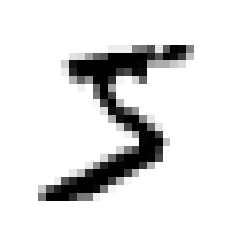

In [ ]:
import matplotlib.pyplot as plt

some_digit=X[0] # 첫번쨰 사진데이터 확인해보겠다.
some_digit_image = some_digit.reshape(28,28) #배열의 구조를 reshape하겠다. (ex- reshape(3,4)면 3x4형태의 배열로 구조를 바꾸겠다는것.)

# https://frhyme.github.io/python-lib/plt_axis_off  // plt.axis관련 좋은 블로그
plt.imshow(some_digit_image, cmap="binary")  #cmap에 binary로 한건 아마 회색음영을 위해 이리 한듯.
plt.axis("off") #라벨(축)등 모든 axis값들 제거하는 옵션("off") 부분제거도 가능
plt.show() #주피터노트북에선 이 코드 생략해도 그려주지만, 일반적인 파이썬 인터프리터에선 이 코드를 써야 그림 그려줌.

In [ ]:
y = y.astype(np.uint8)  # y값이 지금 string으로 되어있으므로, 정수형 값으로 변환하겠음.
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 3.2이진 분류기 훈련 (문제단순화. 5이냐 아니냐만 먼저 테스트 해보자)

타깃벡터 먼저 만들어봤음



In [ ]:
y_train_5 = (y_train == 5) # 라벨값5만 True, 나머지 False
y_test_5 = (y_test==5)

In [ ]:
from sklearn.linear_model import SGDClassifier #무작위성으로 훈련함

sgd_clf = SGDClassifier(max_iter=5, random_state=42) #확률적경사하강법(SGD)한번에 하나씩 훈련샘플 독립적처리함. -> 미니배치학습에 좋다고 한다.
sgd_clf.fit(X_train, y_train_5) # y=uint형 다시 실행하고, 위에거 실행한다음 이거 돌려야 오류 안남(more than 1 클래스 어쩌구 거림)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [ ]:
sgd_clf.predict([some_digit]) #5로 보이는 이미지를 실제로 5라고 예측을 잘했다.(True값을 반환했으니)

array([ True])

# 3.3 성능 측정

In [ ]:
# 3.3.1 교차 검증을 통한 정확도 측정

In [ ]:
#지난시간에 배운것 응용
from sklearn.model_selection import cross_val_score
scores = cross_val_score(sgd_clf,X_train, y_train_5, scoring="accuracy",cv=3) # 분류문제는 기본적으로 accuracy매개변수를 사용해서 정확도 측정한다고 함.
print(scores) #정확도 매우 높게 나오지만...

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


[0.9633  0.95695 0.9146 ]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


※교차검증 직접 구현하는 코드(실제 이런식으로 돌아간다고함. 나중에 직접 제어하려면 익혀두자)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone 
skfolds = StratifiedKFold(n_splits=3, random_state=42) #폴드3개, 난수고정해서 계층적 샘플링을 함.(클래스별 비율 유지위함)

# ★clone을 써야만 하는이유? -> 하나의 Data로 학습된 모델을 쓰는게 목적이아니라, 여러 Fold(훈련set)로 훈련시켜서 측정해보는게 목적이므로 clone 써야함.
for train_index, test_index in skfolds.split(X_train, y_train_5):#매 반복마다 분류기객체를 clone으로 생성해서, Fold데이터로 훈련시키고 예측한다.
  clone_clf = clone(sgd_clf) # clone은 모델만을 그대로 복사하는 함수이다.(Data말고)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.9633


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.95695
0.9146


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [ ]:
# accuracy지표의 단점(편향적인 모델도 성능 좋게 나올수가 있음)

In [ ]:
#무조건 5가 아니라고 예측하는 모델(현재 Dataset중 10%만이 5고 나머지 90%는 5가 아니긴함)
from sklearn.base import BaseEstimator # 이것도 score재보면 정확도 90%이상으로 나온다(안좋은 모델임에도)
class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1),dtype=bool) # np.zeros? 주어진 모양(Shape)과 type대로 0으로 채워진 새 배열을 반환함. (여기선 boolean형태로)
    #즉, Data인풋 크기만큼 받아서 무조건 다 0(5가아님!False!)를 반환하는 배열을 이 Class를 통해 output하는거임. 

# 3.3.2 오차행렬(accuracy방식대신, 분류기 성능 평가할 더 좋은 방법)

오차행렬이란? 예) 분류기가 숫자5의 이미지를 3으로 잘못분류한 횟수를 기억해서 평가하겠다는것. 
숫자분류 모델이 있을때(1?2?3?...) 오차행렬 5행의 3열을 보면, 그 값은 5를 3으로 예측한 값이다.(오차)

In [ ]:
from sklearn.model_selection import cross_val_predict # ※cross_val_score아님! predict다. 예측값만을 결과값으로 반환.
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) # 앞서만든 sgd_clf 즉, 5냐 아니냐 판단하는 모델을 넣어봤음.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred) #실제 타깃벡터, 해당예측값
#오차행렬의 행=실제클래스 // 열=예측한클래스 

array([[52336,  2243],
       [ 1060,  4361]])

In [ ]:
#      5아님예측  5라고예측
#5아님 [52336        2243]    진짜음성(아님예측,진짜아님) 거짓양성(5예측,5아님)
#5임   [1060         4361]    거짓음성(아님예측,5임)      진짜양성(5예측,5임)
# 만약 완벽한 예측기라면, 주 대각선만 0아닌값이고 나머지 0일것임 (정확도 100%)
                          
# TN FP
# FN TP  
#정밀도 = TP/ (TP+FP) 양성예측의 정확도다.(양성 예측한것중 몇개가 제대로 양성 감지헀느냐)
#정확도 = TP+TF / (TP+TF+FP+FT) 전쳬예측의 정확도
#재현율 = TP/(TP+FN) 실제 양성인 놈들중 몇개나 제대로 재현(감지)했는가. 
                             #FN은 거짓음성, 즉 실제론 양성인 놈임!!
                        

https://yamalab.tistory.com/50 #FN,TN,...등 정확도 정밀도 재현도 잘 설명함.


# 3.3.3 정밀도와 재현율 -> 난이도High 제대로 봐보자.

In [ ]:
from sklearn.metrics import precision_score, recall_score #정밀도, 재현율
print(precision_score(y_train_5,y_train_pred)) #정밀도 66% 5로 판별한것중 66%만 정확
print(recall_score(y_train_5,y_train_pred)) #재현율 80% 실제5중에 80%만 제대로 감지.

0.6603573591762568
0.8044641210108836


In [ ]:
# F1점수 (정밀도와 재현율의 조화평균!)
# 2 / [(1/정밀도) + (1/재현율)]
from sklearn.metrics import f1_score #두 분류기를 비교할때 f1점수 자주쓰임.(정밀도 재현도 다 고려하기 위해)
f1_score(y_train_5,y_train_pred) #정밀도와 재현율이 비슷할수록 1에 가까워 진다.


0.7253222453222454

정밀도 - 예측을 했을떄 그 예측이 믿을만한 정도.
정밀한 양치기소년은, 늑대가 오는게 '정말' 확실할때만 늑대다! 라고 소리친다.
(근데 가끔, 늑대가 온거같은 상황일때도 입을 다문다) -> 즉 확실할때만 양성이라분류

재현율 - 실제 값들중 정말로 실제라고 감지된 비율.
'재현율높은' 양치기소년은, 늑대가 아닌데도 민감해서, 조금만 수상해도 늑대다! 소리친다. 
(이 경우, 정밀도는 낮지만 거의 대부분의 늑대를 잡을 수 있다.) -> 즉, 조금만 이상해도 양성이라 분류

In [ ]:
# 정밀도와 재현율, 왜 필요하며 둘다 고려하는가?
#Ex)어린아이 안전동영상 분류 모델을 만든다 치자.(목적-좋은동영상만 보여주기) 
#만약, 재현율이 낮고 정밀도가 높다면(좋다고 예측한놈은 정말로 좋을확률 높다) // 그만큼 나쁘다!라고 예측한쪽이 더 많은거임.
#나쁜동영상! 이라고 예측하고 분류한게 많다는 의미. 잡음이 많이 섞이더라도 
#FN증가?-좋은데 나쁘다 할 확률Up(음성예측했으나 양성,거짓음성),재현율낮고,정밀높
#FP증가?-나쁜놈을 좋다 할 확률Up(양성예측했으나 음성,거짓양성),정밀도낮고,재현높

#SGD분류기의 예측방식?
#임곗값을 기준, 그보다 크면 양성, 작으면 음성임
#Ex)임곗값을 더 증가시켜서... 양성예측(5다)라고 분류하는걸 더 까다롭게 만들었다고 치자.
#그럼 5라고 예측한것중 진짜 5일 확률이 더 증가한다.(100%도 가능)
#하지만, 실제 5의 갯수 대비, 5라고 예측해서 맞춘것이 감소하므로 재현율은 감소한다.

In [ ]:
y_scores = sgd_clf.decision_function([some_digit]) #decison_function은 임곗값 호출하는 함수. 
#some_digit에는 X[0]이 저장되었었음.
y_scores # 예측에 사용한점수 57392. 이 값을 기준으로 양/음성 판단했음.
threshold = 0 #임곗값이 0이라면?
y_some_digit_pred = (y_scores > threshold) #predict()메서드와 동일한 결과, True를 반환함.

threshold=60000
y_some_digit_pred = (y_scores > threshold) #  본 점수 57392보다 크므로 False반환. 5가 아니라고 판단할거임.

In [ ]:
#적절한 임곗값 정하는법 
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
#y_scores에 예측결과가 아니라 결정점수를 저장함.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [ ]:
from sklearn.metrics import precision_recall_curve # 위의 y_scores점수로 이 함수에서 모든 임곗값에 대해 정밀도,재현율 계산가능
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [ ]:
precisions>=0.90

array([False, False, False, ...,  True,  True,  True])

# 정밀도, 재현율 시각화하기 

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


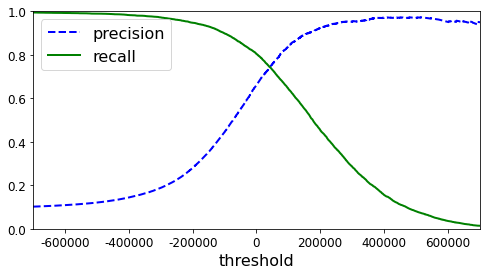

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): #임계값에 대한 정밀도,재현율 그래프
    plt.plot(thresholds, precisions[:-1], "b--", label="precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="recall", linewidth=2)
    plt.xlabel("threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
#save_fig("precision_recall_vs_threshold_plot")
plt.show()

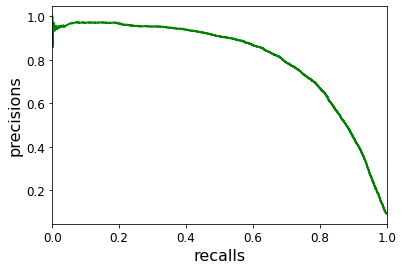

In [ ]:
def plot_precision_vs_recall(precisions, recalls): #재현율에 대한 정밀도 그래프(정밀도가 메인으로 먼저 보임)
    plt.plot(recalls[:-1], precisions[:-1], "g-", label="precisions/recalls", linewidth=2)
    plt.xlabel("recalls", fontsize=16)
    plt.ylabel("precisions",fontsize=16)
    plt.xlim([0, 1])

plot_precision_vs_recall(precisions,recalls)


In [ ]:
# 특정 조건에서의 임곗값 얼마인지 추출
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)] #정밀도 적어도 90%일때 가장 낮은 임곗값 argmin써야 조건만족하는것중
#정밀도90일때(True값들 쭉 반환) 그중 최댓값(여기선 첫번쨰True,즉 최소임곗값)의 위치값을 반환함. 그게 thresholds인덱스로 들어간다.
# np.argmax()? 최댓값의 인덱스값 출력하는거. 최댓값 어딨는지 위치 반환.
print(threshold_90_precision) # 163633

163633.30315197556


# 3.3.5 ROC 곡선

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores) #roc커브결과값, 거짓양성비, 진짜양성비, 임곗값을 저장

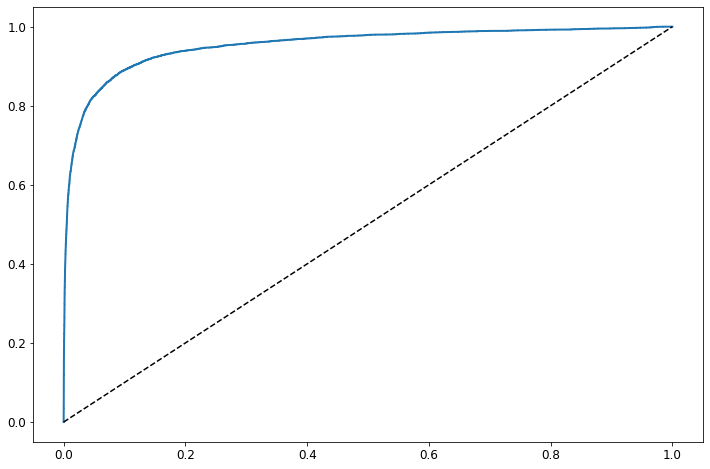

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1],[0,1],'k--')
  
plt.figure(figsize=(12,8))
plot_roc_curve(fpr,tpr)
plt.show()

AUC(Area Under Curve)-곡선 아래의 면적. 위의 ROC곡선 밑의 면적을 계산한 값이다. 완벽한 분류기일 경우(TPR=1, FPR=0이라서 곡선이 맨왼쪽위에 닿은경우...) 그 값은 1이며
랜덤 분류기일경우(위의 점선) 삼각형 넓이계산에 의해 0.5이다.
사이킷럿에서 roc AUC계산하는 함수를 제공한다.

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores) # 0.961 워낙 한쪽값이 많아서 좋게나옴. 이 경우엔, ROC곡선보다 앞서그린 PR커브(재현율대한정밀도곡선)이 더 낫다.
# 즉, 일반적으로 양성이 많이 적으면 PR커브, 그 반대면 ROC곡선이 좋다는것!

0.9536789698168869

SGD분류기 대신 랜덤포레스트 써보기 // 얜 특성상 결정함수관련 메서드없음(decision_function X) 대신, predict_proba메서드 사용하겠다.


In [ ]:
from sklearn.ensemble import RandomForestClassifier 
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5, cv=3, method="predict_proba") #predict_proba는 샘플이 행, 클래스가 열이고
#샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환하는 메서드다. ex)어떤 이미지(샘플)이 5(클래스)일 확률 70%등...

In [ ]:
y_probas_forest.shape # 6만개자료, 클래스는2개( 5냐 아니냐)
y_probas_forest[0] # 첫번째 샘플이 5에 안속할확률 0.11 5일확률 0.89
y_probas_forest[:,1]# 5에 속할 확률만을 뽑아내는 방법. 

In [ ]:
# 원래 roc_curve는 레이블과 점수(결정함수)를 기대한다. 점수대신, 클래스에 속할 확률넣겠음.
y_scores_forest = y_probas_forest[:,1] #양성클래스에 대한 확률을 점수로 쓰겠다
# 의미상 거의 비슷! 왜냐? 임곗값이 클수록 양성일 가능성 높으니 어찌보면 확률 관련된 계수라 볼 수 있지.(정답인 레이블은 True False느낌이고...)
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

In [ ]:
plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,"RandomForest")
plt.legend(loc="lower right")
plt.show() # 랜덤포레스트가 SGD분류기보다 훨 성능이 좋다.(왼쪽위로 더욱 수렴해있음)

In [ ]:
roc_auc_score(y_train_5, y_scores_forest) #auc면적(점수) 굉장히 높다.정밀도,재현율도 해보면 각각 99%, 86.6% 나옴.

# 3.4 다중분류

In [ ]:
#다중분류방법? OvR vs OvO (원 versus Rest) (원 Versus All) 전략
#Ex)특정 숫자 하나만 구분하는 숫자별(0~9)이진분류기 10개를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템 만들기.<이게 OvR>
# 또는 0+1 0+2 ... 이렇게 45개 조합에 대해 One Versus One으로 훈련

OvO는 각 분류기를 훈련시킬때(MNIST의 경우 45개) 구별할 두 클래스에 해당하는 샘플만 필요하다는 특징(장점)이 있다.
Ex) 0과1구분? 전체 샘플중 0, 1에 해당하는 것만 넣어서 훈련(소형세트로 훈련)대신 여러번 훈련시켜야 한다.
OvR은 반대로, 거대한 훈련세트에서 몇개(Mnist는10개)의 분류기 훈련.(SVM은 이방식이 느리다고함.) -> But, 대부분 OvR방식을 이진분류 알고리즘이 선호.

In [ ]:
from sklearn.svm import SVC #사포트벡터분류기. 
#다중클래스분류작업, 이진분류알고리즘(SVM)사용시 자동으로 OvO나 OvR을 실행한다.(0~9이미지와 0~9답을 담은 train의 X,y넣어서 훈련시킴.)

In [ ]:
#svm_clf = SVC() # SVM으로 했더니 겁나 느리다. 걍 sgd로 바꿔서 실험해보는것이 나을듯.
#svm_clf.fit(X_train,y_train)
#svm_clf.predict([some_digit])
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train,y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [ ]:
#some_digit_scores = svm_clf.decision_function([some_digit]) #결정함수가 10개의 점수를 가지고 있음.(OvO로 총10개 모델 학습했기 떄문. 이중 최댓값으로 분류함)
#some_digit_scores
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [ ]:
#np.argmax(some_digit_scores) # 위에서 분류한 놈의 클래스를 출력한다.
# svm_clf.classes_ # 0~9까지 클래스탙입을 호출.
# svm_clf.classes_[5] #인덱스5에 해당하는 클래스값, 5를 출력
np.argmax(some_digit_scores)
sgd_clf.classes_
sgd_clf.classes_[3]

3

OvO나 OvR강제로 쓰게 하는법(함수 임포트하기)

밑에서 SGD분류가로 실험하긴 했으나, 사실 SGD는 그 자체로 다중 클래스 분류가 가능한 놈임. So, 별도로 OvO나 OvR을 적용할 필요가 없다.(임포트할 필요 X)

In [ ]:
#from sklearn.multiclass import OneVsRestClassifier
#ovr_clf = OneVsRestClassifier(SVC())
#ovr_clf.fit(X_train,y_train)
#ovr_clf.predict([some_digit])
#len(ovr_clf.estimators_)

from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier())
ovo_clf.fit(X_train,y_train)
ovo_clf.predict([some_digit]) #ovr로는 sgd가 3이라 예측하더니, ovo로 SGD학습시키니 5라고 제대로 맞췄다.

array([5], dtype=uint8)

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy") # 교차검증으로 SGD분류기 정확도를 평가해보겠다. #물론 실제로 모델이 잘될진 모름! 참고용이라 보면 될듯.
#왜? test데이터나 실제현실Data를 잘 예측해 줘야하니까.

array([0.88565, 0.8786 , 0.88985])

In [ ]:
# 스케일링으로 성능 높이기

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64)) # Scale을 통해 정확도 높이기
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy") #성능이 평균 5%씩은 더 증가했다.

array([0.9002, 0.8952, 0.905 ])

# 3.5 에러분석

In [ ]:
y_train_pred= cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
#오차행렬 이미지로 표현
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True) #오차갯수로만하면, 이미지갯수 많은 클래스가 불리하니, 비율로 나타내보겠다.
norm_conf_mx = conf_mx/row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx,0) #0을0으로 1을1로, 즉 제대로맞춘 주대각선만 0으로 채워서 그래프를 그리겠다.
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show() # 이미지가 밝을수록 에러가 많음.

In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

In [ ]:
#subplot? 그림 여러개! subplot(num1 num2 num3) num1=열갯수 num2=행갯수 num3=해당 그림의 위치
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] # 타겟값이 3인데 3이라 잘 예측한경우의 이미지
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] # 타겟값이 3인데 5라 잘못 예측한 경우 
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] # 타겟값이 5인데 3이라 잘못 예측한 경우
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)] # 타겟값이 5인데 5라 잘 예측한 경우


plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

# 3.6 다중 레이블 분류


분류기가 샘플마다 여러개의 클래스를 출력해야 할때(다중 레이블)
-> Ex) 한 이미지에 밥이 있느냐? 이 사진은 누구냐?(한픽셀정보->한인물 레이블X)
한 이미지에 밥,리사,스티븐있느냐? 이 사진 누구누구?(한픽셀->여러인물 구분,다중레이블)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >=7) #라벨1. 7보다 큰가? 
y_train_odd = (y_train%2==1) #라벨2. 홀수인가?(2로나눈나머지=1?)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
knn_clf.predict([some_digit]) #다중예측 잘될거임  
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro") # average=macro?모든레이블 가중치 같게. average=weighted? 클래스별 샘플수 비례해서 가중치 둠

※ Macro vs Micro 평균 방식
Macro방식은, 각각의 클래스 범주별로 Recall, Precision, F1을 따로따로 구한다. 그래서 그 값들을 클래스갯수(n)대로 나누어서 평균냄.
Micro방식은, 전체 T,F로만 나타낸 Pooled행렬 하나를 가지고 Recall,Precision,F1을 한번에 구한다.

# 다중 출력 분류(다중 출력 다중 클래스 분류)
-지금까진 5냐?(이진) 아니면 어떤 숫자냐?(여러 숫자<다중>중에서) 정도만 했다면...

In [ ]:
# 이진분류 - 각샘플 -> 하나의 클래스 -> 하나의 레이블(예측)
# 다중분류 - 각샘플 -> 여러개의 클래스 -> 하나의 레이블(예측) ex) [0,1,0] 클래스b다!
# 다중 출력 분류 - 각샘플 -> 여러개의 클래스 -> 여러 레이블(예측) ex) [1,0,0],[0,1,0]

In [ ]:
#실제 응용(잡음제거)
noise = np.random.randint(0,100, (len(X_train),784)) #784개의 픽셀정보를 담고있는 0~100사이 난수를 6만개(Train사이즈)만큼 생성!
X_train_mod = X_train + noise
noise = np.random.randint(0,100, (len(X_test),784))
X_test_mod = X_test+noise
y_train_mod = X_train #잡음이 섞인 이미지 X_mod를 통해 원래의 이미지 y_mod를 맞춰야함.(그래서 원본X_train을 여기 저장)
y_test_mod = X_test

In [ ]:
X_test_mod[5500].shape

In [ ]:
# 잡음이 섞인 이미지 출력해보기

some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.save_fig("noisy_digit_example_plot")
plt.show()

NameError: ignored

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod,y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

In [ ]:
knn_clf.predict([some_digit])

# 3장 연습문제

In [ ]:
#1. MNIST 테스트 정확도 97%달성하기
knn_clf.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
from sklearn.metrics import accuracy_score
knn_y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, knn_y_pred) #정확도 측정(아마 97%안뜰거임)

0.9688

In [ ]:
#하이퍼파라미터 탐색
from sklearn.model_selection import GridSearchCV

param_grid = [
              {'n_neighbors' : [3,4,5]}, 
              {'weights': ['uniform','distance']}
]
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search.best_score_

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


In [ ]:
#2 MNIST 픽셀 이동
from scipy.ndimage.interpolation import shift # shift말고 rotate도 있더군
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [ ]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [ ]:
knn_clf.fit(X_train_augmented, y_train_augmented)

In [ ]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)